In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.preprocessing.sequence as sequence
import tensorflow.keras.utils as utils

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# on multi gpu machines, set which gpu to use
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1521982982878091355
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8704345527652444141
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7511012148
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10803507645490609866
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15245934443775809880
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
def split_data(df, frac=0.1):
    """
    Split the data by the post id.
    Equations from the same post will be in the same set.
    """
    split_by = df.post_id
    post_ids = df.post_id.unique()
    N = len(post_ids)
    
    test_posts = np.random.choice(post_ids, int(N * frac))
    n_test = len(test_posts)
    test_condition = df.post_id.isin(test_posts)
    return df[~test_condition], df[test_condition]

In [100]:
np.random.seed(1)
datapath = Path('../data/processed/equations.csv')
df = pd.read_csv(datapath)
print('Null Data: ', df.equation.isnull().sum())
df.dropna(subset=['equation'], inplace=True)
df = df.drop_duplicates(subset=['equation', 'source'])

df = df[df['source'] != 'biology.stackexchange.com']
df = df[df.apply(lambda row: "=" in row.equation, axis = 1)]

train_df, test_df = split_data(df, 0.1)
train_df, val_df = split_data(train_df, 0.1)

print(f'Training rows: {train_df.shape[0]}')
print(f'Val rows: {val_df.shape[0]}')
print(f'Test rows: {test_df.shape[0]}')

Null Data:  2
Training rows: 260553
Val rows: 26994
Test rows: 30527


In [101]:
class Tokenizer:
    """Convert chars to ints"""
    def __init__(self):
        self.UNK = '<UNK>'  # Unknown
        self.BOS = '<BOS>'  # Begin of string
        self.EOS = '<EOS>'  # End of string
        self.PAD = '<PAD>'  # Padding
        self.char_to_idx = dict()
        self.idx_to_char = dict()
        self.vocab = []
        
        self.specials = [self.PAD, self.BOS, self.EOS, self.UNK]
        for c in self.specials: self.add(c)
        
    
    def __getitem__(self, c: str):
        try:
            return self.char_to_idx[c]
        except KeyError:
            return self.char_to_idx[self.UNK]
    
    def fit(self, sequences):
        """Create the vocab from a sequence of strings"""
        chars = set.union(*map(set, sequences))
        for char in chars: self.add(char)

    def add(self, c: str):
        """Add the character if its not in the vocab, else do nothing"""
        if self.char_to_idx.get(c) is None:
            self.char_to_idx[c] = len(self.vocab)
            self.idx_to_char[len(self.vocab)] = c
            self.vocab.append(c)
        return len(self.vocab)

    
def encode_sequence(seq, tokenizer):
    return [tokenizer[tokenizer.BOS]] + [tokenizer[c] for c in seq] + [tokenizer[tokenizer.EOS]]

In [102]:
tokenizer = Tokenizer()
tokenizer.fit(train_df.equation)

# convert string to list of int
train_df['seq'] = train_df.equation.apply(encode_sequence, args=(tokenizer,))
val_df['seq'] = val_df.equation.apply(encode_sequence, args=(tokenizer,))
test_df['seq'] = test_df.equation.apply(encode_sequence, args=(tokenizer,))

train_df['length'] = train_df.seq.apply(len)
val_df['length'] = val_df.seq.apply(len)
test_df['length'] = test_df.seq.apply(len)

labels = train_df.source.unique()
label_map = {label: i for i, label in enumerate(labels)}

train_df['label'] = train_df.source.map(label_map)
val_df['label'] = val_df.source.map(label_map)
test_df['label'] = test_df.source.map(label_map)


/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [103]:
encode_sequence('1234', tokenizer)

[1, 121, 39, 95, 104, 2]

In [104]:
tokenizer['4']

104

In [105]:
label_map

{'physics.stackexchange.com': 0, 'chemistry.stackexchange.com': 1}

In [106]:
train_df.sample(10)

,equation,post_id,score,source,type,user_id,seq,length,label
381795,f(\kappa_2 a) =1,218872,2,physics.stackexchange.com,Posts,26168.0,"[1, 282, 97, 85, 144, 188, 225, 225, 188, 98, ...",18,0
635487,K = h\nu - w,336932,1,physics.stackexchange.com,Posts,118357.0,"[1, 276, 66, 116, 66, 58, 85, 147, 205, 66, 15...",14,0
237724,\sigma= |A+B|^2,147490,2,physics.stackexchange.com,Posts,64701.0,"[1, 85, 182, 190, 261, 281, 188, 116, 66, 6, 2...",18,0
969651,"[α,β]=(-1)^{pq+1}[β,α]",483320,3,physics.stackexchange.com,Posts,137338.0,"[1, 11, 176, 129, 294, 179, 116, 97, 153, 121,...",24,0
852773,2a/ℏ*{sqrt(2m(E_n + V_0))} = n\pi,434644,0,physics.stackexchange.com,Posts,209429.0,"[1, 39, 188, 183, 174, 256, 79, 182, 30, 124, ...",35,0
1122559,A = \sum_{i} \lambda_i P_{\lambda_{i}},9564,8,physics.stackexchange.com,Posts,1236.0,"[1, 66, 273, 66, 116, 66, 85, 182, 205, 281, 9...",42,0
333963,E_g(M) = - \frac{3 G M^2}{5 R(M)},16266,2,physics.stackexchange.com,Posts,1255.0,"[1, 56, 98, 261, 97, 208, 87, 66, 116, 66, 153...",35,0
290095,s = h,173098,0,physics.stackexchange.com,Posts,58059.0,"[1, 182, 66, 116, 66, 58, 2]",7,0
213683,F_{fict} = -ma_{frame},136021,1,physics.stackexchange.com,Posts,55662.0,"[1, 66, 29, 98, 79, 282, 190, 275, 55, 140, 66...",25,0
1006245,y(t) = -10t^2 + v_y t + y_1,60596,0,physics.stackexchange.com,Posts,NaN,"[1, 296, 97, 55, 87, 66, 116, 66, 153, 121, 22...",29,0


In [107]:
class DataGenerator(utils.Sequence):
    def __init__(self, df, batch_size: int = 32, shuffle: bool = False, weight: bool = False):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.weight = weight
        self.class_weight =  self.compute_class_weight() if self.weight else np.ones((3,))
        
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            

    def get_data_at_index(self, batch_idx):
        offset = self.batch_size * batch_idx
        return self.df.iloc[offset: offset+self.batch_size]
    
    def __getitem__(self, batch_idx: int):
        batch = self.get_data_at_index(batch_idx)
        if self.shuffle:
            batch = batch.sample(frac=1)

        X = sequence.pad_sequences(
            batch.seq,
            maxlen=min( max(batch.length), 32),
            truncating='post',
        )
        Y = batch.label.values
        w = np.array([self.class_weight[label] for label in Y])
        return X, Y, w
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            
    def __len__(self):
        return int(np.ceil( self.df.shape[0] / self.batch_size ))
    
    def compute_class_weight(self):
        n_classes = 3
        n_samples = self.df.shape[0]
        return n_samples / (n_classes * np.bincount(self.df.label.values))


In [108]:
# ensure balanced classes
# N_train = train_df.groupby('source').count().values.min()
# N_val = val_df.groupby('source').count().values.min()

# small_df = pd.concat([train_df[train_df.label==l].sample(N_train, replace=False) for l in range(3)])
# small_val_df = pd.concat([val_df[val_df.label==l].sample(N_val, replace=False) for l in range(3)])

batch_size = 1024
train_dg = DataGenerator(train_df, batch_size=batch_size, shuffle=True, weight=True)
val_dg = DataGenerator(val_df, batch_size=batch_size, shuffle=False, weight=False)


In [109]:
class Mask(layers.Layer):
    def call(self, inputs):
        value = tf.cast(0, dtype=inputs.dtype)
        is_zero = tf.equal(inputs, value)
        return tf.cast(tf.logical_not(is_zero), tf.float32)

        
class ApplyMask(layers.Layer):
    def call(self, inputs):
        data, mask = inputs
        mask = tf.expand_dims(mask, axis=-1)  # (N, T, 1)
        return tf.multiply(data, mask)

In [110]:
def clf_model(tokenizer):
    
    emb = 32
    n_kernels = 128
    kernel_width = 3
    
    # define layers
    input = layers.Input(batch_shape=(None, None))  # (N, T)
    embedding_layer = layers.Embedding(len(tokenizer.vocab), emb, mask_zero=False, name='embedding')  # (N, T, emb)
    mask_layer = Mask(name='mask')  # (N, T)
    conv_layer = layers.Conv1D(
        n_kernels, kernel_width, 
        activation='tanh',
        kernel_initializer='he_normal',
        padding='same',
        name='conv'
    )  # (N, T, n_kernels), selects 3-grams
    apply_mask_layer = ApplyMask(name='apply_mask')  # (N, T, n_kernels), zero the timesteps that were padding
    rnn_layer = layers.LSTM(n_kernels, name='rnn') # (N, e)
    softmax_layer = layers.Dense(3, activation='softmax', name='output')
    
    # call layers
    embedding = embedding_layer(input)
    mask = mask_layer(input)
    conv = conv_layer(embedding)
    conv = apply_mask_layer([conv, mask])
    encoded = rnn_layer(conv)
    output = softmax_layer(encoded)
    model = models.Model(input, output)
    return model
    
def compile_model(model):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['sparse_categorical_accuracy']
    )


In [111]:
model = clf_model(tokenizer)  # initialize the weights
compile_model(model)  # set the loss fn and optimizer
print(model.summary())  # check the number of parameters


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     9504        input_2[0][0]                    
__________________________________________________________________________________________________
conv (Conv1D)                   (None, None, 128)    12416       embedding[0][0]                  
__________________________________________________________________________________________________
mask (Mask)                     (None, None)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [112]:
history = model.fit_generator(
    train_dg,
    validation_data=val_dg,
    epochs=32,
    workers=3,
    use_multiprocessing=True
)

Epoch 1/32
255/255 [==============================] - 21s 82ms/step - loss: 0.3485 - sparse_categorical_accuracy: 0.7762 - val_loss: 0.4546 - val_sparse_categorical_accuracy: 0.7966
Epoch 2/32
255/255 [==============================] - 19s 75ms/step - loss: 0.2991 - sparse_categorical_accuracy: 0.8223 - val_loss: 0.4853 - val_sparse_categorical_accuracy: 0.7834
Epoch 3/32
255/255 [==============================] - 19s 73ms/step - loss: 0.2831 - sparse_categorical_accuracy: 0.8331 - val_loss: 0.3513 - val_sparse_categorical_accuracy: 0.8600
Epoch 4/32
255/255 [==============================] - 19s 73ms/step - loss: 0.2706 - sparse_categorical_accuracy: 0.8443 - val_loss: 0.4264 - val_sparse_categorical_accuracy: 0.8178
Epoch 5/32
255/255 [==============================] - 18s 72ms/step - loss: 0.2620 - sparse_categorical_accuracy: 0.8516 - val_loss: 0.3310 - val_sparse_categorical_accuracy: 0.8657
Epoch 6/32
255/255 [==============================] - 19s 73ms/step - loss: 0.2543 - spars

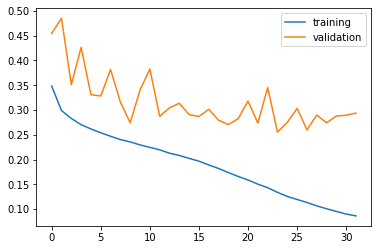

In [114]:
%matplotlib inline

plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

name = "model3_epoch32_1"
plt.savefig('../result/loss/' + name + '.png', dpi=200)

plt.show()

# Evaluation

## evaluation tools

In [115]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

%matplotlib inline

def plot_confusion_matrix(y_true, y_pred, classes, name,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.savefig('../result/confusion_matrix/' + name + '.png', dpi=200)
    return ax

In [116]:
def predict_on_df(model, df):
    dg = DataGenerator(df, batch_size=32, shuffle=False)
    yhat = model.predict_generator(dg)
    pred_index = yhat.argmax(axis=1)
    pred_conf = yhat.max(axis=1)
    df['pred_index'] = pred_index
    df['pred_label'] = df.pred_index.apply(lambda x: list(label_map.keys())[x])
    df['pred_conf'] = pred_conf
    df['match'] = df['pred_index'] == df['label']
    return df


def display_top_losses(prediction_df, k: int = 10):
    wrong_condition = ~prediction_df.match
    wrong_df = prediction_df[wrong_condition]
    return wrong_df.sort_values('pred_conf', ascending=False).iloc[0:k][['equation', 'pred_label', 'source', 'pred_index', 'label', 'pred_conf']]
    
def predict_from_str(equation, model, tokenizer):
    X = np.array([encode_sequence(equation, tokenizer)])
    yhat = model.predict(X)
    pred_index = yhat.argmax()
    label = [label for label, i in label_map.items() if i==pred_index][0]
    return {
        'yhat': yhat.tolist(),
        'pred_index': pred_index,
        'label': label
           }

## evaluate

In [119]:
test_df

,equation,post_id,score,source,type,user_id,seq,length,label
52,"g=((g_{11},0),(0,g_{22}))",140506,0,physics.stackexchange.com,Comments,5374.0,"[1, 261, 116, 97, 97, 261, 98, 79, 121, 121, 1...",27,0
83,\rho=1,140678,4,physics.stackexchange.com,Comments,5477.0,"[1, 85, 124, 58, 86, 116, 121, 2]",8,0
107,\bar{k}^2 = 0,140771,0,physics.stackexchange.com,Comments,26206.0,"[1, 85, 219, 188, 124, 79, 144, 140, 181, 39, ...",15,0
108,k \bar{k} = 1,140771,0,physics.stackexchange.com,Comments,26206.0,"[1, 144, 66, 85, 219, 188, 124, 79, 144, 140, ...",15,0
167,{\delta S\over \delta \phi} =0,141067,0,physics.stackexchange.com,Comments,4864.0,"[1, 79, 85, 250, 252, 78, 55, 188, 66, 271, 85...",32,0
168,S = \int L(\phi) + J \phi,141067,0,physics.stackexchange.com,Comments,4864.0,"[1, 271, 66, 116, 66, 85, 190, 147, 55, 66, 10...",27,0
276,B=\Phi A,141460,0,physics.stackexchange.com,Comments,6316.0,"[1, 272, 116, 85, 7, 58, 190, 66, 273, 2]",10,0
282,T_{\mu\nu}=0,141468,0,physics.stackexchange.com,Comments,26299.0,"[1, 53, 98, 79, 85, 281, 205, 85, 147, 205, 14...",14,0
301,A(x)=∑A_i(x)B_i,141498,0,physics.stackexchange.com,Comments,6316.0,"[1, 273, 97, 288, 87, 116, 70, 273, 98, 190, 9...",17,0
302,|A(x)⟩=∑A_i(x)|B_i⟩,141498,0,physics.stackexchange.com,Comments,6316.0,"[1, 6, 273, 97, 288, 87, 258, 116, 70, 273, 98...",21,0


In [120]:
predictions = predict_on_df(model, test_df)

/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [123]:
test_df

,equation,post_id,score,source,type,user_id,seq,length,label,pred_index,pred_label,pred_conf,match
52,"g=((g_{11},0),(0,g_{22}))",140506,0,physics.stackexchange.com,Comments,5374.0,"[1, 261, 116, 97, 97, 261, 98, 79, 121, 121, 1...",27,0,0,physics.stackexchange.com,0.993578,True
83,\rho=1,140678,4,physics.stackexchange.com,Comments,5477.0,"[1, 85, 124, 58, 86, 116, 121, 2]",8,0,1,chemistry.stackexchange.com,0.863823,False
107,\bar{k}^2 = 0,140771,0,physics.stackexchange.com,Comments,26206.0,"[1, 85, 219, 188, 124, 79, 144, 140, 181, 39, ...",15,0,0,physics.stackexchange.com,0.999999,True
108,k \bar{k} = 1,140771,0,physics.stackexchange.com,Comments,26206.0,"[1, 144, 66, 85, 219, 188, 124, 79, 144, 140, ...",15,0,0,physics.stackexchange.com,0.729845,True
167,{\delta S\over \delta \phi} =0,141067,0,physics.stackexchange.com,Comments,4864.0,"[1, 79, 85, 250, 252, 78, 55, 188, 66, 271, 85...",32,0,0,physics.stackexchange.com,1.000000,True
168,S = \int L(\phi) + J \phi,141067,0,physics.stackexchange.com,Comments,4864.0,"[1, 271, 66, 116, 66, 85, 190, 147, 55, 66, 10...",27,0,0,physics.stackexchange.com,0.999999,True
276,B=\Phi A,141460,0,physics.stackexchange.com,Comments,6316.0,"[1, 272, 116, 85, 7, 58, 190, 66, 273, 2]",10,0,0,physics.stackexchange.com,0.999994,True
282,T_{\mu\nu}=0,141468,0,physics.stackexchange.com,Comments,26299.0,"[1, 53, 98, 79, 85, 281, 205, 85, 147, 205, 14...",14,0,0,physics.stackexchange.com,0.999999,True
301,A(x)=∑A_i(x)B_i,141498,0,physics.stackexchange.com,Comments,6316.0,"[1, 273, 97, 288, 87, 116, 70, 273, 98, 190, 9...",17,0,0,physics.stackexchange.com,0.999950,True
302,|A(x)⟩=∑A_i(x)|B_i⟩,141498,0,physics.stackexchange.com,Comments,6316.0,"[1, 6, 273, 97, 288, 87, 258, 116, 70, 273, 98...",21,0,0,physics.stackexchange.com,0.999923,True


In [124]:
# test_df = test_df[test_df['pred_index']!=2]

Confusion matrix, without normalization
[[25482  2477]
 [  715  1853]]


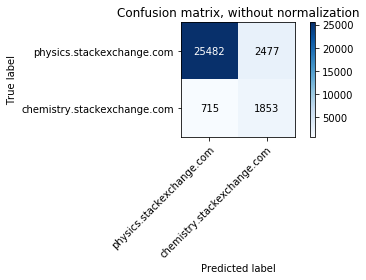

In [121]:
name = "model3_epoch32_1"
plot_confusion_matrix(predictions.label, predictions.pred_index, np.array(list(label_map.keys())), name)


Normalized confusion matrix
[[0.91140599 0.08859401]
 [0.27842679 0.72157321]]


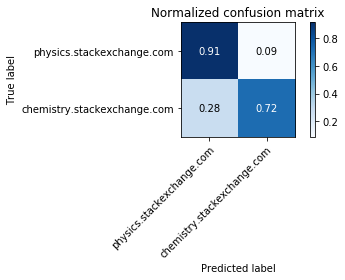

In [122]:
name = "model3_epoch32_2"
plot_confusion_matrix(predictions.label, predictions.pred_index, np.array(list(label_map.keys())), name, normalize=True)


In [125]:
predict_from_str('H\PSI = E\PSI', model, tokenizer)

{'yhat': [[0.23588426411151886, 0.7641156315803528, 7.60205338679043e-08]],
 'pred_index': 1,
 'label': 'chemistry.stackexchange.com'}

In [126]:
display_top_losses(predictions, 20)

,equation,pred_label,source,pred_index,label,pred_conf
1222434,G_i = H_i - TS_i \qquad (5),physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.000000
1305302,H_z=\frac{\mu}{\hbar}(L_z+2S_z)B,physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.000000
1282812,\chi_l(R(\pi))=(-1)^l,physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.000000
1315245,[K_c] = \mathrm{dim}(c)^{Δn},physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.000000
1203931,Q=[(u_V+Pv_V)-(u_L+Pv_L)]\Delta n=(h_V-h_L)\De...,physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.000000
1267614,F=\gamma l \Delta \theta,physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.000000
1265458,H\ket{n} = E_n \ket{n} \tag{5},physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.000000
207372,I_\alpha=MR_\alpha^2,physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.000000
1183315,\Lambda=\Lambda_0-a\sqrt c,physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.000000
191094,E=m\cdot\mathcal{c}^2,physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.000000
